In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./Y_train.csv', index_col=0)

train_home_team_statistics_df.columns = 'HOME_' + train_home_team_statistics_df.columns
train_away_team_statistics_df.columns = 'AWAY_' + train_away_team_statistics_df.columns

train_data = train_home_team_statistics_df.iloc[:,2:].join(train_away_team_statistics_df.iloc[:,2:])

In [3]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
class MatchTeamClassifier(nn.Module):
    def __init__(self, n_class, n_team_fts, hidden_team):
        super().__init__()
        self.hidden = hidden_team
        self.bc1 = nn.BatchNorm1d(n_team_fts)
        self.bc2 = nn.BatchNorm1d(hidden_team[0])
        self.att1 = nn.MultiheadAttention(hidden_team[0], 1, batch_first=True)
        self.fc1 = nn.Linear(n_team_fts, hidden_team[0])
        self.fc2 = nn.Linear(hidden_team[0], hidden_team[1])
        self.bc3 = nn.BatchNorm1d(hidden_team[1])
        self.att2 = nn.MultiheadAttention(hidden_team[1], 1, batch_first=True)
        self.fc3 = nn.Linear(hidden_team[1], hidden_team[2])
        self.bc4 = nn.BatchNorm1d(hidden_team[2])
        self.att3 = nn.MultiheadAttention(hidden_team[2], 1, batch_first=True)
        self.fc4 = nn.Linear(hidden_team[2], n_class)

    def forward(self, x):
        res = self.bc2(self.fc1(self.bc1(x)))[:,None,:]
        res = self.att1(res, res, res, need_weights=False)[0]
        res = self.bc3(self.fc2(res)[:,0,:]).reshape(-1, 1, self.hidden[1])
        res = self.att2(res, res, res, need_weights=False)[0]
        res = self.bc4(self.fc3(res)[:,0,:]).reshape(-1, 1, self.hidden[2])
        res = self.att3(res, res, res, need_weights=False)[0]
        return self.fc4(res)[:,0,:]

In [28]:
net = MatchTeamClassifier(3, 280, (128, 64, 32))

x_train = torch.Tensor(X_train.replace({np.nan:0.0}).values)
x_valid = torch.Tensor(X_valid.replace({np.nan:0.0}).values)
Y_train = torch.Tensor(y_train.values)
Y_valid = torch.Tensor(y_valid.values)

In [29]:
print(net(x_valid).shape)
net.bc1.requires_grad_(False)
net.bc3.requires_grad_(False)
net.bc4.requires_grad_(False)

torch.Size([2461, 3])


BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [30]:
import copy

torch.set_flush_denormal(True)
N_EPOCHS = 10000 # + 100
net.train()
criterion = nn.CrossEntropyLoss() # loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

train_accuracies = [1.0]
val_accuracies = [1.0]
val_check = 1
best_state, best_val = None, 0.0
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform SGD step.
    optimizer.zero_grad()
    y_pred = net(x_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()
    train_acc, val_acc = accuracy_score(torch.argmax(y_pred, axis=1), torch.argmax(Y_train, axis=1)), val_accuracies[-1]
    if(epoch % val_check == 0):
        hat_y_val = net(x_valid)
        #val_loss = criterion(hat_y_val, y_val)
        val_acc = accuracy_score(torch.argmax(hat_y_val, axis=1), torch.argmax(Y_valid, axis=1))
        if(val_acc > best_val):
            best_val = val_acc
            best_state = copy.deepcopy(net.state_dict())

    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")

Epoch 0 Loss 1.10 | Train Accuracy 0.382137776874619 | Val Accuracy 0.47013409183258836
Epoch 1 Loss 1.05 | Train Accuracy 0.46403170087380613 | Val Accuracy 0.4790735473384803
Epoch 2 Loss 1.03 | Train Accuracy 0.48384474700264174 | Val Accuracy 0.48679398618447783
Epoch 3 Loss 1.02 | Train Accuracy 0.49126193863035966 | Val Accuracy 0.4863876472978464
Epoch 4 Loss 1.02 | Train Accuracy 0.49512294249136357 | Val Accuracy 0.4904510361641609
Epoch 5 Loss 1.01 | Train Accuracy 0.49624060150375937 | Val Accuracy 0.49207639171068673
Epoch 6 Loss 1.01 | Train Accuracy 0.49786628733997157 | Val Accuracy 0.4904510361641609
Epoch 7 Loss 1.01 | Train Accuracy 0.4977646819752083 | Val Accuracy 0.4965461194636327
Epoch 8 Loss 1.01 | Train Accuracy 0.5028449502133713 | Val Accuracy 0.4989841527834214
Epoch 9 Loss 1.01 | Train Accuracy 0.5002032107295266 | Val Accuracy 0.5002031694433158
Epoch 10 Loss 1.01 | Train Accuracy 0.500406421459053 | Val Accuracy 0.49410808614384394
Epoch 11 Loss 1.01 | Tr

In [8]:
print(net.state_dict())

OrderedDict([('bc1.weight', tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

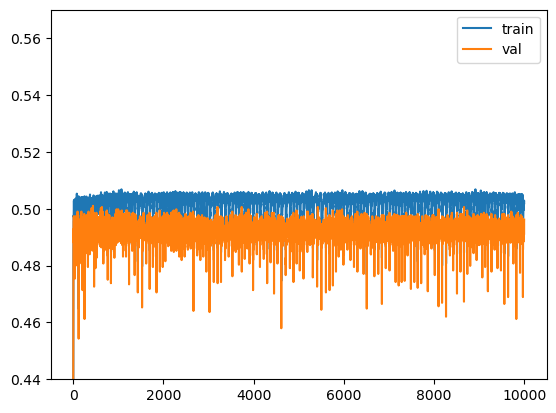

In [27]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_accuracies[1:])), train_accuracies[1:], label = "train")
plt.plot(np.arange(len(train_accuracies[1:])), val_accuracies[1:], label = "val")
plt.legend(loc="best")
plt.ylim(0.44, 0.57)
plt.show()

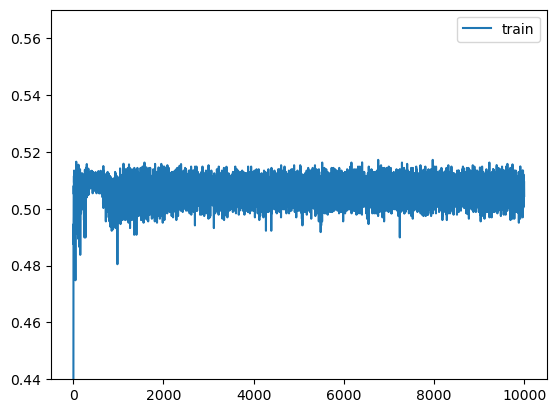

In [35]:
plt.plot(np.arange(len(train_accuracies[1:])), np.minimum(val_accuracies[1:], train_accuracies[1:]), label = "train")
plt.legend(loc="best")
plt.ylim(0.44, 0.57)
plt.show()

In [22]:
#print(val_accuracies)
#print(train_accuracies)
torch.save(best_state, "MCT_params_best2")
#torch.save(net.state_dict(), "MCT_params_last")
#net = MatchClassifier(3,4,302,278,300)
#net.load_state_dict(torch.load("MC1_params"))

In [25]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
#print(val_accuracies)
#print(train_accuracies)
#torch.save(net.state_dict(), "MC1_params")
net = MatchTeamClassifier(3,280,(512,64))
net.load_state_dict(torch.load("MCT_params_best"))

hat_y_val = torch.argmax(net(x_valid), axis=1)
y_val = torch.argmax(Y_valid, axis=1)
#print(confusion_matrix(y_val, hat_y_val, normalize="pred"))
#print(np.unique(torch.argmax(Y_valid, axis=1), return_counts=True))
print(accuracy_score(y_val, hat_y_val))

0.5030475416497359


## Player data
To ameliorate the performance, we take the player individual data into account.

In [4]:
train_home_player_statistics_df = pd.read_csv('./train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('./train_away_player_statistics_df.csv', index_col=0)
train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)
train_home_team_statistics_df.columns = 'HOME_' + train_home_team_statistics_df.columns
train_away_team_statistics_df.columns = 'AWAY_' + train_away_team_statistics_df.columns


train_scores = pd.read_csv('./Y_train.csv', index_col=0)

In [5]:
import pickle

lin_model_position = pickle.load(open("pos_model", "rb"))
encoding = ["attacker", "defender", "goalkeeper", "midfielder"]


train_home_player_statistics_df.loc[train_home_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(train_home_player_statistics_df.iloc[:,4:].replace({np.nan:0.0}))])[train_home_player_statistics_df.isna()["POSITION"]]
train_away_player_statistics_df.loc[train_away_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(train_away_player_statistics_df.iloc[:,4:].replace({np.nan:0.0}))])[train_away_player_statistics_df.isna()["POSITION"]]

df = train_away_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_away = df.set_index("ID").groupby("POSITION")
positions = ["attacker", "goalkeeper", "midfielder", "defender"]
m1 = np.intersect1d(gb_away.get_group(positions[0]).index, gb_away.get_group(positions[1]).index)
m2 = np.intersect1d(gb_away.get_group(positions[2]).index, gb_away.get_group(positions[3]).index)
away_m = np.intersect1d(m1, m2)

df = train_home_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_home = df.set_index("ID").groupby("POSITION")
m1 = np.intersect1d(gb_home.get_group(positions[0]).index, gb_home.get_group(positions[1]).index)
m2 = np.intersect1d(gb_home.get_group(positions[2]).index, gb_home.get_group(positions[3]).index)
home_m = np.intersect1d(m1, m2)

m = np.intersect1d(away_m, home_m)

train_player_data = []
useless_features = open("lines.txt", "r").readlines()
useless_features = [ft[:-1] for ft in useless_features]
print(useless_features)
for pos in positions:
    df_home_pos = gb_home.get_group(pos).drop(useless_features, axis=1)
    df_away_pos = gb_away.get_group(pos).drop(useless_features, axis=1)
    df_home_pos.columns = 'HOME_' + df_home_pos.columns
    df_away_pos.columns = 'AWAY_' + df_away_pos.columns
    train_player_data.append(df_home_pos.iloc[:,1:].join(df_away_pos.iloc[:,1:]))

['PLAYER_CAPTAIN_5_last_match_average', 'PLAYER_CAPTAIN_5_last_match_std', 'PLAYER_CAPTAIN_season_average', 'PLAYER_CAPTAIN_season_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_average', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_sum', 'PLAYER_LONG_BALLS_5_last_match_average', 'PLAYER_LONG_BALLS_5_last_match_std', 'PLAYER_LONG_BALLS_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_5_last_match_average', 'PLAYER_LONG_BALLS_WON_5_last_match_std', 'PLAYER_LONG_BALLS_WON_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_season_average', 'PLAYER_LONG_BALLS_WON_season_std', 'PLAYER_LONG_BALLS_WON_season_sum', 'PLAYER_LONG_BALLS_season_average', 'PLAYER_LONG_BALLS_season_std', 'PLAYER_LONG_BALLS_season_sum', 'PLAYER_PENALTIES_SAVED_5_last_match_average', 'PLAYER_PENALTIES_SAVED_5_last_match_std', 'PLAYER_PENALTIES_SAVED_5_last_match_sum', 'PLAYER_PENALTIES_SAVED_season_average', 'PLAYER_PENALTIES_SAVED_season_std', 'PLAYER_PENALTIES_SAVED_season_sum', 'PLAYER_PENALTIE

In [6]:
train_player_data[0].columns = "ATTACK_" + train_player_data[0].columns
train_player_data[1].columns = "GOALKEEP_" + train_player_data[1].columns
train_player_data[2].columns = "MIDFIELD_" + train_player_data[2].columns
train_player_data[3].columns = "DEFEND_" + train_player_data[3].columns

X_train = train_home_team_statistics_df.iloc[m,2:].join(train_away_team_statistics_df.iloc[m,2:].join(train_player_data[0].loc[m,:].join(train_player_data[1].loc[m,:].join(train_player_data[2].loc[m,:].join(train_player_data[3].loc[m,:])))))

In [7]:
select_fts = open("feature_selection.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
X_train = X_train[select_fts]
print(X_train)

       HOME_TEAM_SHOTS_INSIDEBOX_season_sum  \
ID                                            
0                                       2.0   
1                                       8.0   
2                                       2.0   
3                                       5.0   
4                                       3.0   
...                                     ...   
12296                                   0.0   
12297                                   NaN   
12299                                   2.0   
12300                                   3.0   
12302                                   3.0   

       HOME_TEAM_SHOTS_TOTAL_5_last_match_sum  HOME_TEAM_GAME_LOST_season_sum  \
ID                                                                              
0                                         4.0                            10.0   
1                                         5.0                             1.0   
2                                         5.0                   

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, train_scores.loc[m,:], train_size=0.8, random_state=42)

In [19]:
net = MatchTeamClassifier(3, 512, (256,))

x_train = torch.Tensor(X_train.replace({np.nan:0.0}).values)
x_valid = torch.Tensor(X_valid.replace({np.nan:0.0}).values)
Y_train = torch.Tensor(y_train.values)
Y_valid = torch.Tensor(y_valid.values)

print(net(x_valid).shape)
net.bc1.requires_grad_(False)
torch.set_flush_denormal(True)

torch.Size([2125, 3])


True

In [37]:
import copy

N_EPOCHS = 10000 # + 100
net.train()
criterion = nn.CrossEntropyLoss() # loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

train_accuracies = [1.0]
val_accuracies = [1.0]
val_check = 1
best_state, best_val = None, 0.0
best_min_state, best_min_val = None, 0.0
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform SGD step.
    optimizer.zero_grad()
    y_pred = net(x_train)
    loss = criterion(y_pred, Y_train)
    loss.backward()
    optimizer.step()
    train_acc, val_acc = accuracy_score(torch.argmax(y_pred, axis=1), torch.argmax(Y_train, axis=1)), val_accuracies[-1]
    if(epoch % val_check == 0):
        hat_y_val = net(x_valid)
        #val_loss = criterion(hat_y_val, y_val)
        val_acc = accuracy_score(torch.argmax(hat_y_val, axis=1), torch.argmax(Y_valid, axis=1))
        if(val_acc > best_val):
            best_val = val_acc
            best_state = copy.deepcopy(net.state_dict())

        if(min(val_acc, train_acc) > best_min_val):
            best_min_val = min(val_acc, train_acc)
            best_min_state = copy.deepcopy(net.state_dict())

    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")

Epoch 0 Loss 0.99 | Train Accuracy 0.522414401694317 | Val Accuracy 0.4258823529411765
Epoch 1 Loss 1.10 | Train Accuracy 0.4180491822567361 | Val Accuracy 0.45647058823529413
Epoch 2 Loss 1.06 | Train Accuracy 0.4464054594658195 | Val Accuracy 0.4814117647058824
Epoch 3 Loss 1.04 | Train Accuracy 0.4741734321684904 | Val Accuracy 0.4955294117647059
Epoch 4 Loss 1.02 | Train Accuracy 0.48982233203906345 | Val Accuracy 0.5091764705882353
Epoch 5 Loss 1.02 | Train Accuracy 0.49676432521473113 | Val Accuracy 0.5134117647058823
Epoch 6 Loss 1.02 | Train Accuracy 0.49641134251088365 | Val Accuracy 0.5129411764705882
Epoch 7 Loss 1.02 | Train Accuracy 0.4955877162019061 | Val Accuracy 0.5124705882352941
Epoch 8 Loss 1.02 | Train Accuracy 0.4952347334980586 | Val Accuracy 0.5115294117647059
Epoch 9 Loss 1.02 | Train Accuracy 0.4952347334980586 | Val Accuracy 0.5129411764705882
Epoch 10 Loss 1.02 | Train Accuracy 0.4955877162019061 | Val Accuracy 0.5152941176470588
Epoch 11 Loss 1.02 | Train A

In [42]:
torch.save(best_min_state, "MCT_P_params_best_min")

In [4]:
select_fts = open("team_fs.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
X_train = X_train[select_fts]
X_valid = X_valid[select_fts]
print(X_train)
print(X_valid)

       HOME_TEAM_GAME_WON_season_sum  \
ID                                     
9107                             5.0   
8231                             2.0   
5367                            10.0   
3264                             4.0   
9590                             1.0   
...                              ...   
11964                            2.0   
5191                             5.0   
5390                             4.0   
860                              1.0   
7270                             0.0   

       HOME_TEAM_BALL_POSSESSION_season_average  \
ID                                                
9107                                        4.0   
8231                                        0.0   
5367                                        6.0   
3264                                        5.0   
9590                                        1.0   
...                                         ...   
11964                                       2.0   
5191                

In [10]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=10000,learning_rate=0.005,depth=4) # 3,4,5
# Fit model

model.fit(X_train.values, np.argmax(y_train.values, axis=1), eval_set=(X_valid.values, np.argmax(y_valid.values, axis=1)), early_stopping_rounds=500)
# Get predictions
preds = model.predict(X_valid)

0:	learn: 1.0980339	test: 1.0980462	best: 1.0980462 (0)	total: 15.5ms	remaining: 2m 35s
1:	learn: 1.0974461	test: 1.0974877	best: 1.0974877 (1)	total: 25.9ms	remaining: 2m 9s
2:	learn: 1.0968395	test: 1.0969383	best: 1.0969383 (2)	total: 37ms	remaining: 2m 3s
3:	learn: 1.0962418	test: 1.0963918	best: 1.0963918 (3)	total: 46.6ms	remaining: 1m 56s
4:	learn: 1.0956599	test: 1.0958316	best: 1.0958316 (4)	total: 55.8ms	remaining: 1m 51s
5:	learn: 1.0950924	test: 1.0952977	best: 1.0952977 (5)	total: 65.2ms	remaining: 1m 48s
6:	learn: 1.0945138	test: 1.0947618	best: 1.0947618 (6)	total: 76.1ms	remaining: 1m 48s
7:	learn: 1.0939664	test: 1.0942338	best: 1.0942338 (7)	total: 87.4ms	remaining: 1m 49s
8:	learn: 1.0934304	test: 1.0937084	best: 1.0937084 (8)	total: 96.7ms	remaining: 1m 47s
9:	learn: 1.0929360	test: 1.0932496	best: 1.0932496 (9)	total: 109ms	remaining: 1m 49s
10:	learn: 1.0923804	test: 1.0927504	best: 1.0927504 (10)	total: 119ms	remaining: 1m 48s
11:	learn: 1.0918586	test: 1.0922421

In [11]:
print(preds)
print(accuracy_score(preds, np.argmax(y_valid.values, axis=1)))
print(accuracy_score(model.predict(X_train.values), np.argmax(y_train.values, axis=1)))

[[0]
 [0]
 [2]
 ...
 [2]
 [0]
 [2]]
0.49939049167005284
0.5081284291810607


In [60]:
#model.save_model("catboost")
#model.load_model("catboost")
#preds = model.predict(X_valid)
#print(accuracy_score(preds, np.argmax(y_valid.values, axis=1)))

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:72: Feature 281 is present in model but not in pool.

## Submission

In [7]:
test_home_team_statistics_df = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)

test_home_team_statistics_df.columns = 'HOME_' + test_home_team_statistics_df.columns
test_away_team_statistics_df.columns = 'AWAY_' + test_away_team_statistics_df.columns

test_data = test_home_team_statistics_df.join(test_away_team_statistics_df)

In [41]:
import pickle

test_home_player_statistics_df = pd.read_csv('./test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('./test_away_player_statistics_df.csv', index_col=0)

lin_model_position = pickle.load(open("pos_model", "rb"))
encoding = ["attacker", "defender", "goalkeeper", "midfielder"]


test_home_player_statistics_df.loc[test_home_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(test_home_player_statistics_df.iloc[:,1:].replace({np.nan:0.0}))])[test_home_player_statistics_df.isna()["POSITION"]]
test_away_player_statistics_df.loc[test_away_player_statistics_df.isna()["POSITION"],"POSITION"] = (np.array(encoding)[lin_model_position.predict(test_away_player_statistics_df.iloc[:,1:].replace({np.nan:0.0}))])[test_away_player_statistics_df.isna()["POSITION"]]

df = test_away_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_away = df.set_index("ID").groupby("POSITION")
positions = ["attacker", "goalkeeper", "midfielder", "defender"]
m1 = np.intersect1d(gb_away.get_group(positions[0]).index, gb_away.get_group(positions[1]).index)
m2 = np.intersect1d(gb_away.get_group(positions[2]).index, gb_away.get_group(positions[3]).index)
away_m = np.intersect1d(m1, m2)

df = test_home_player_statistics_df.reset_index().groupby(["POSITION", "ID"], as_index=False).sum()
gb_home = df.set_index("ID").groupby("POSITION")
m1 = np.intersect1d(gb_home.get_group(positions[0]).index, gb_home.get_group(positions[1]).index)
m2 = np.intersect1d(gb_home.get_group(positions[2]).index, gb_home.get_group(positions[3]).index)
home_m = np.intersect1d(m1, m2)

m = np.intersect1d(away_m, home_m)

test_player_data = []
useless_features = open("lines.txt", "r").readlines()
useless_features = [ft[:-1] for ft in useless_features]
print(useless_features)
for pos in positions:
    df_home_pos = gb_home.get_group(pos).drop(useless_features, axis=1)
    df_away_pos = gb_away.get_group(pos).drop(useless_features, axis=1)
    df_home_pos.columns = 'HOME_' + df_home_pos.columns
    df_away_pos.columns = 'AWAY_' + df_away_pos.columns
    test_player_data.append(df_home_pos.iloc[:,1:].join(df_away_pos.iloc[:,1:]))


test_player_data[0].columns = "ATTACK_" + test_player_data[0].columns
test_player_data[1].columns = "GOALKEEP_" + test_player_data[1].columns
test_player_data[2].columns = "MIDFIELD_" + test_player_data[2].columns
test_player_data[3].columns = "DEFEND_" + test_player_data[3].columns

X_test = test_home_team_statistics_df.loc[m,:].join(test_away_team_statistics_df.loc[m,:].join(test_player_data[0].loc[m,:].join(test_player_data[1].loc[m,:].join(test_player_data[2].loc[m,:].join(test_player_data[3].loc[m,:])))))

select_fts = open("feature_selection.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
X_test = X_test[select_fts]

['PLAYER_CAPTAIN_5_last_match_average', 'PLAYER_CAPTAIN_5_last_match_std', 'PLAYER_CAPTAIN_season_average', 'PLAYER_CAPTAIN_season_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_average', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_std', 'PLAYER_CLEARANCE_OFFLINE_5_last_match_sum', 'PLAYER_LONG_BALLS_5_last_match_average', 'PLAYER_LONG_BALLS_5_last_match_std', 'PLAYER_LONG_BALLS_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_5_last_match_average', 'PLAYER_LONG_BALLS_WON_5_last_match_std', 'PLAYER_LONG_BALLS_WON_5_last_match_sum', 'PLAYER_LONG_BALLS_WON_season_average', 'PLAYER_LONG_BALLS_WON_season_std', 'PLAYER_LONG_BALLS_WON_season_sum', 'PLAYER_LONG_BALLS_season_average', 'PLAYER_LONG_BALLS_season_std', 'PLAYER_LONG_BALLS_season_sum', 'PLAYER_PENALTIES_SAVED_5_last_match_average', 'PLAYER_PENALTIES_SAVED_5_last_match_std', 'PLAYER_PENALTIES_SAVED_5_last_match_sum', 'PLAYER_PENALTIES_SAVED_season_average', 'PLAYER_PENALTIES_SAVED_season_std', 'PLAYER_PENALTIES_SAVED_season_sum', 'PLAYER_PENALTIE

In [52]:
team_model = MatchTeamClassifier(3, 280, (300,))
#player_model = MatchTeamClassifier(3, 512, (256,))

team_state = torch.load("MCT_params_best")
for key in list(team_state.keys()):
    team_state[key.replace('att2', 'att1').replace('fc2', 'fc3')] = team_state.pop(key)

print(team_state.keys())


team_model.load_state_dict(team_state)
#player_model.load_state_dict(torch.load("MCT_P_params_best_min"))
player_model = model

y_player = player_model.predict(X_train.values)
y_team = team_model(torch.Tensor(train_data.replace({np.nan:0.0}).values))
print("team : ", accuracy_score(torch.argmax(y_team, axis=1), torch.argmax(torch.Tensor(train_scores.values), axis=1)))
print("player : ", accuracy_score(y_player, np.argmax(y_train.values, axis=1)))


odict_keys(['bc1.weight', 'bc1.bias', 'bc1.running_mean', 'bc1.running_var', 'bc1.num_batches_tracked', 'bc2.weight', 'bc2.bias', 'bc2.running_mean', 'bc2.running_var', 'bc2.num_batches_tracked', 'att1.in_proj_weight', 'att1.in_proj_bias', 'att1.out_proj.weight', 'att1.out_proj.bias', 'fc1.weight', 'fc1.bias', 'fc3.weight', 'fc3.bias'])
team :  0.4999593595058116
player :  0.5446523120367102


In [8]:
#net.eval()
d = {'HOME_WINS':[0 for i in range(len(test_data))], 'DRAW':[0 for i in range(len(test_data))], "AWAY_WINS":[0 for i in range(len(test_data))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)
#y_pred = player_model(torch.Tensor(X_test.replace({np.nan:0.0}).values))
#scores = torch.argmax(y_pred, axis=1)
y_pred = player_model.predict(X_test.values)
scores = y_pred[:,0]

test_score.loc[m[scores == 0], "HOME_WINS"] = 1
test_score.loc[m[scores == 1], "DRAW"] = 1
test_score.loc[m[scores == 2], "AWAY_WINS"] = 1

y_pred = team_model(torch.Tensor(test_data.replace({np.nan:0.0}).values))
team_scores = np.array(torch.argmax(y_pred, axis=1))
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 0), 0] = 1
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 1), 1] = 1
test_score.iloc[(test_score["HOME_WINS"] == 0) & (test_score["DRAW"] == 0) & (test_score["AWAY_WINS"] == 0) & (team_scores == 2), 2] = 1

test_score.reset_index(inplace=True)
test_score.to_csv("Catboost.csv", index=False)

NameError: name 'player_model' is not defined

In [8]:
select_fts = open("team_fs.txt", "r").readlines()
select_fts = [ft[:-1] for ft in select_fts]
test_data = test_data[select_fts]

In [9]:
d = {'HOME_WINS':[0 for i in range(len(test_data))], 'DRAW':[0 for i in range(len(test_data))], "AWAY_WINS":[0 for i in range(len(test_data))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)

y_pred = model.predict(test_data.values)
team_scores = y_pred[:,0]
test_score.iloc[team_scores == 0, 0] = 1
test_score.iloc[team_scores == 1, 1] = 1
test_score.iloc[team_scores == 2, 2] = 1

test_score.reset_index(inplace=True)
test_score.to_csv("CatboostTeam.csv", index=False)